In [4]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [14]:
meth = pd.read_csv('meth_DNMT3A.tsv', sep = '\t', dtype = {'chr':str })
print(meth.head())

  chr    start      end strand  coverage1  numCs1  numTs1  coverage2  numCs2  \
1   1  3020794  3020794      +        191       3     188        147       0   
2   1  3020814  3020814      +        191     188       3        147     133   
3   1  3020891  3020891      +        260     248      12        209     197   
4   1  3037820  3037820      +        165     131      34        187     156   
5   1  3037825  3037825      +        165     149      16        187     175   

   numTs2  coverage3  numCs3  numTs3  coverage4  numCs4  numTs4  coverage5  \
1     147        197       0     197        227       0     227        180   
2      14        199     197       2        227     221       6        180   
3      12        216     201      15        253     232      21        262   
4      31        206     167      39        248     209      39        244   
5      12        206     200       6        248     231      17        246   

   numCs5  numTs5  
1       1     179  
2     166 

In [15]:
colnames = meth.columns.tolist()
numTs = [i for i in colnames if i.startswith('numTs')]
coverage = [i for i in colnames if i.startswith('coverage')]

In [16]:
for i in range(1, len(numTs) +1 ):
    coverage_col = 'coverage' + str(i)  # Variable name changed to avoid overwriting
    numTs_col = 'numTs' + str(i)  # Variable name changed to avoid overwriting
    numCs_col = 'numCs' + str(i)
    
    # Calculate percentage of methylation for each row and assign to a new column
    meth['pr_methylated_' + str(i)] = (meth[numTs_col] / meth[coverage_col]) * 100
    meth['pr_unmethylated_' + str(i)] = (meth[numCs_col] / meth[coverage_col]) * 100
    

In [17]:
#MAKE A DICTIONARY STORING THE DATA SEPARATELY FOR DIFFERENT DATAFRAMES
chromosomes = meth.groupby('chr')
dataframes = {}
for name, group in chromosomes:
    dataframes[name] = group.copy()

In [18]:
print(dataframes['1'].columns)

Index(['chr', 'start', 'end', 'strand', 'coverage1', 'numCs1', 'numTs1',
       'coverage2', 'numCs2', 'numTs2', 'coverage3', 'numCs3', 'numTs3',
       'coverage4', 'numCs4', 'numTs4', 'coverage5', 'numCs5', 'numTs5',
       'pr_methylated_1', 'pr_unmethylated_1', 'pr_methylated_2',
       'pr_unmethylated_2', 'pr_methylated_3', 'pr_unmethylated_3',
       'pr_methylated_4', 'pr_unmethylated_4', 'pr_methylated_5',
       'pr_unmethylated_5'],
      dtype='object')


In [19]:
#columns_to_drop = ['chr', 'start', 'strand', 'coverage1', 'numCs1', 'numTs1',
#       'coverage2', 'numCs2', 'numTs2', 'coverage3', 'numCs3', 'numTs3',
#       'coverage4', 'numCs4', 'numTs4', 'coverage5', 'numCs5', 'numTs5']

#USING BOTH NUM TS AND NUM CS
#columns_to_drop = ['chr', 'start', 'strand', 'coverage1',
#       'coverage2', 'coverage3', 'coverage4', 'coverage5',
#       'pr_methylated_1', 'pr_methylated_2', 'pr_methylated_3',
#'pr_methylated_4', 'pr_methylated_5']
columns_to_drop = ['chr', 'start', 'strand', 'coverage1', 'numCs1', 'numTs1',
       'coverage2', 'numCs2', 'numTs2', 'coverage3', 'numCs3', 'numTs3',
       'coverage4', 'numCs4', 'numTs4', 'coverage5', 'numCs5', 'numTs5']

chr8 = dataframes['8']
#ONLY KEEPING NumTs information
chr8_Ts_drop = ['chr', 'start', 'strand', 'coverage1', 'numCs1',
       'coverage2', 'numCs2',  'coverage3', 'numCs3', 
       'coverage4', 'numCs4',  'coverage5', 'numCs5', 
       'pr_methylated_1', 'pr_methylated_2', 'pr_methylated_3',
       'pr_methylated_4', 'pr_methylated_5']

#ONLY KEEPING THE COVERAGE INFORMATION
chr8_coverage_drop = ['chr', 'start', 'strand',  'numCs1', 'numTs1',
        'numCs2', 'numTs2',  'numCs3', 'numTs3',
        'numCs4', 'numTs4', 'numCs5', 'numTs5',
       'pr_methylated_1', 'pr_methylated_2', 'pr_methylated_3',
       'pr_methylated_4', 'pr_methylated_5']

chr = chr8.copy()
chr8_dr = chr.drop(columns = columns_to_drop)
chr = chr8.copy()
chr8_Ts = chr.copy().drop(columns = chr8_Ts_drop)
chr = chr8.copy()
chr8_coverage = chr.copy().drop(columns = chr8_coverage_drop)


#print(chr8)

In [20]:
#CONVERT NUM CS TO NEGATIVE NUMBERS SO THAT WE HAVE TWO TYPES OF INFORMATION ON TWO SIDES OF 0
def convert_numCs(df):
    df2 = df.copy()
    for col in df2.columns:
        if col.startswith('numCs'):
            df2[col] = df2[col].apply(lambda x: x * -1)
    return df2

chr8_dr = convert_numCs(chr8_dr)

#print(chr8_dr)

In [21]:
columns_to_drop = ['chr', 'start', 'strand', 'coverage1', 'numCs1', 'numTs1',
       'coverage2', 'numCs2', 'numTs2', 'coverage3', 'numCs3', 'numTs3',
       'coverage4', 'numCs4', 'numTs4', 'coverage5', 'numCs5', 'numTs5']

In [23]:
chr8 = dataframes['8']
chr = chr8.copy()
chr8_dr = chr.drop(columns = columns_to_drop)

In [24]:
def reshape_dataframe_percentage(df):
    id_vars = ['end']
    value_vars = [col for col in df.columns if col.startswith('pr') ]
    # Melt the DataFrame
    melted_df = pd.melt(df, id_vars=id_vars, value_vars=value_vars, var_name='patient_id', value_name='percentage')
    
    # Extract patient_id from column names
    melted_df['patient_id'] = melted_df['patient_id'].str.split('_', expand=True)[2].astype(int)
    
    return melted_df

In [25]:
chr8_dr = convert_numCs(chr8_dr)

In [26]:
reshaped = reshape_dataframe_percentage(chr8_dr)

In [27]:
def plot_meth_pattern(df, df_name, palette='tab10', savefig=False):
    plt.figure(figsize=(12, 8)) 
    palette = {1: 'red', 2: 'lightcoral', 3: 'navy', 4: 'blue', 5: 'cornflowerblue'}
    
    # Separate data into positive and negative percentages
    df_plus = df[df['percentage'] > 0]
    df_minus = df[df['percentage'] < 0]
    
    # Plot bars for positive percentages
    sns.barplot(data=df_plus, x='end', y='percentage', hue='patient_id', palette=palette, alpha=0.7)
    
    # Plot bars for negative percentages
    sns.barplot(data=df_minus, x='end', y='percentage', hue='patient_id', palette=palette, alpha=0.7)
    
    # Draw a wide line at y = 0
    plt.axhline(y=0, color='black', linewidth=3)
    
    plt.xlabel('Position')
    plt.ylabel('Ts count')

    plt.title('Methylation pattern, {}, TET2'.format(df_name))
    plt.xticks(rotation=90)
    
    if savefig:
        name = df_name + '_percentage.jpg'
        plt.savefig(name)
    plt.show()


In [28]:
#GET DAtAFRAMES FOR DIFFERENT CHROMOSOMES
chr1 = dataframes['1']
chr2 = dataframes['2']
chr3 = dataframes['3']
chr4 = dataframes['4']
chr5 = dataframes['5']
chr6 = dataframes['6']
chr7 = dataframes['7']
chr8 = dataframes['8']
chr9 = dataframes['9']
chr10 = dataframes['10']
chr11 = dataframes['11']
chr12 = dataframes['12']
chr13 = dataframes['13']
chr14 = dataframes['14']
chr15 = dataframes['15']
chr16 = dataframes['16']
chr17 = dataframes['17']
chr18 = dataframes['18']
chr19 = dataframes['19']
chrX = dataframes['X']
chrY = dataframes['Y']

In [29]:
#DROP COLUMNS PERCENTAGE PLOTTING 
chr1 = chr1.copy().drop(columns = columns_to_drop)
chr2 = chr2.copy().drop(columns = columns_to_drop)
chr3 = chr3.copy().drop(columns = columns_to_drop)
chr4 = chr4.copy().drop(columns = columns_to_drop)
chr5 = chr5.copy().drop(columns = columns_to_drop)
chr6 = chr6.copy().drop(columns = columns_to_drop)
chr7 = chr7.copy().drop(columns = columns_to_drop)
chr8 = chr8.copy().drop(columns = columns_to_drop)
chr9 = chr9.copy().drop(columns = columns_to_drop)
chr10 = chr10.copy().drop(columns = columns_to_drop)
chr11 = chr11.copy().drop(columns = columns_to_drop)
chr12 = chr12.copy().drop(columns = columns_to_drop)
chr13 = chr13.copy().drop(columns = columns_to_drop)
chr14 = chr14.copy().drop(columns = columns_to_drop)
chr15 = chr15.copy().drop(columns = columns_to_drop)
chr16 = chr16.copy().drop(columns = columns_to_drop)
chr17 = chr17.copy().drop(columns = columns_to_drop)
chr18 = chr18.copy().drop(columns = columns_to_drop)
chr19 = chr19.copy().drop(columns = columns_to_drop)
chrX = chrX.copy().drop(columns = columns_to_drop)
chrY = chrY.copy().drop(columns = columns_to_drop)

In [30]:
#CONVERT Cs TO MINUS VALUES
chr1 = convert_numCs(chr1)
chr2 = convert_numCs(chr2)
chr3 = convert_numCs(chr3)
chr4 = convert_numCs(chr4)
chr5 = convert_numCs(chr5)
chr6 = convert_numCs(chr6)
chr7 = convert_numCs(chr7)
chr8 = convert_numCs(chr8)
chr9 = convert_numCs(chr9)
chr10 = convert_numCs(chr10)
chr11 = convert_numCs(chr11)
chr12 = convert_numCs(chr12)
chr13 = convert_numCs(chr12)
chr14 = convert_numCs(chr14)
chr15 = convert_numCs(chr15)
chr16 = convert_numCs(chr16)
chr17 = convert_numCs(chr17)
chr18 = convert_numCs(chr18)
chr19 = convert_numCs(chr19)
chrX = convert_numCs(chrX)
chrY = convert_numCs(chrY)

In [31]:
#RESHAPE PERCENTAGE PLOTTING
chr1_re = reshape_dataframe_percentage(chr1)
chr2_re = reshape_dataframe_percentage(chr2)
chr3_re = reshape_dataframe_percentage(chr3)
chr4_re = reshape_dataframe_percentage(chr4)
chr5_re = reshape_dataframe_percentage(chr5)
chr6_re = reshape_dataframe_percentage(chr6)
chr7_re = reshape_dataframe_percentage(chr7)
chr8_re = reshape_dataframe_percentage(chr8)
chr9_re = reshape_dataframe_percentage(chr9)
chr10_re = reshape_dataframe_percentage(chr10)
chr11_re = reshape_dataframe_percentage(chr11)
chr12_re = reshape_dataframe_percentage(chr12)
chr13_re = reshape_dataframe_percentage(chr13)
chr14_re = reshape_dataframe_percentage(chr14)
chr15_re = reshape_dataframe_percentage(chr15)
chr16_re = reshape_dataframe_percentage(chr16)
chr17_re = reshape_dataframe_percentage(chr17)
chr18_re = reshape_dataframe_percentage(chr18)
chr19_re = reshape_dataframe_percentage(chr19)
chrX_re = reshape_dataframe_percentage(chrX)
chrY_re = reshape_dataframe_percentage(chrY)

KeyboardInterrupt: 

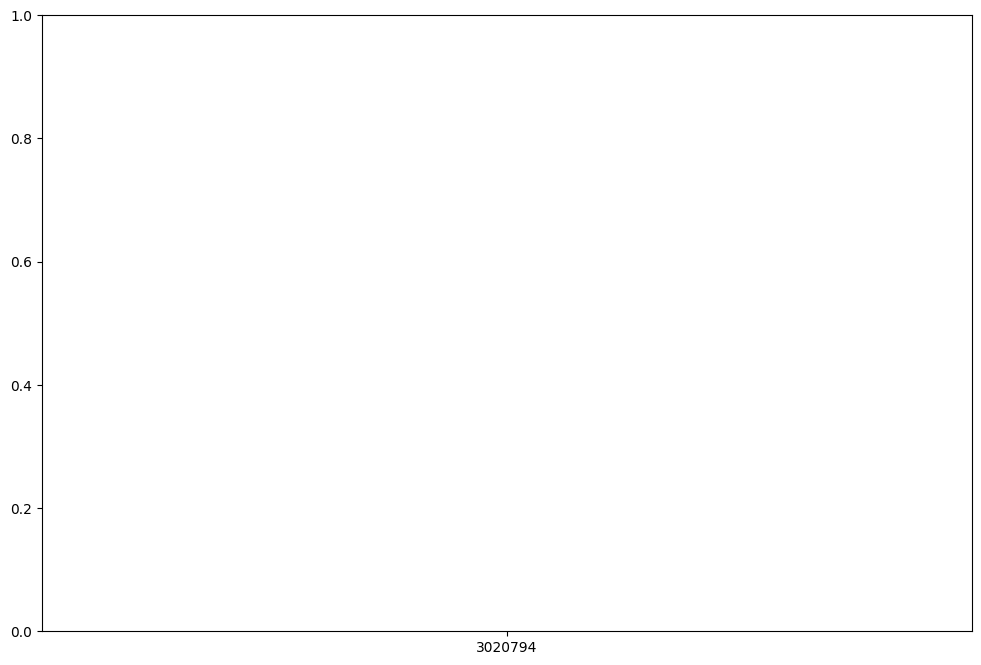

In [32]:
plot_meth_pattern(chr1_re, 'chr1', palette = 'tab10', savefig = False)
plot_meth_pattern(chr2_re, 'chr2', palette = 'tab10', savefig = False)
plot_meth_pattern(chr3_re, 'chr3', palette = 'tab10', savefig = False)
plot_meth_pattern(chr4_re, 'chr4', palette = 'tab10', savefig = False)
plot_meth_pattern(chr5_re, 'chr5', palette = 'tab10', savefig = False)
plot_meth_pattern(chr6_re, 'chr6', palette = 'tab10', savefig = False)
plot_meth_pattern(chr7_re, 'chr7', palette = 'tab10', savefig = False)
plot_meth_pattern(chr8_re, 'chr8', palette = 'tab10', savefig = False)
plot_meth_pattern(chr9_re, 'chr9', palette = 'tab10', savefig = False)
plot_meth_pattern(chr10_re, 'chr10', palette = 'tab10', savefig = False)
plot_meth_pattern(chr11_re, 'chr11', palette = 'tab10', savefig = False)
plot_meth_pattern(chr12_re, 'chr12', palette = 'tab10', savefig = False)


BEDGRAPH PRODUCTION

I didn't visualis